# **Objective**
Develop a credit card customer segmentation to define marketing strategy.

# **Outline**

[**1. Dataset Features**](#Dataset-Features)


[**2. Preprocessing**](#Preprocessing)

> [* Missing Values Treatment](#Missing-Values-Treatment)

> [* Feature Distribution - KDE plot](#Feature-Distribution)

> [* Outliers Treatment](#Outliers-Treatment)

> [* Correlation Matrix](#Correlation-Matrix)

> [* Create Interaction Features](#Create-Interaction-Features)

> [* Feature Digitization](#Feature-Digitization)


[**3. Modeling**](#Modeling)

> [* Evaluation Metric - Silhouette Score](#Evaluation-Metric---Silhouette-Score)

> [* Model - KMeans](#Model---KMeans)


[**4. Visualization**](#Visualization)

> [* Line Plot - Silhouette Score under Various Number of Cluster](#Line-Plot---Silhouette-Score-under-Various-Number-of-Cluster)

> [* Scatter Plot - Cluster Results](#Scatter-Plot---Cluster-Results)

> [* Histogram - Features Value of Each Cluster](#Histogram---Features-Value-of-Each-Cluster)

> [* Render Plot - Features Value of Each Cluster](#Render-Plot---Features-Value-of-Each-Cluster)


[**5. Features of customers in each group**](#Features-of-customers-in-each-group)

# **Dataset Features**<a></a>

**1. Balance**
* BALANCE: Balance amount left in their account to make purchases (
* BALANCEFREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

**2. Purchases**
* PURCHASES: Amount of purchases made from account
* ONEOFFPURCHASES: Maximum purchase amount done in one-go
* INSTALLMENTSPURCHASES: Amount of purchase done in installment

**3. Purchases Frequency**
* PURCHASESFREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
* ONEOFFPURCHASESFREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
* PURCHASESINSTALLMENTSFREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
* PURCHASESTRX: Number of purchase transactions made

**4. Cash Advance**
* CASHADVANCE: Cash in advance given by the user
* CASHADVANCEFREQUENCY: How frequently the cash in advance being paid
* CASHADVANCETRX: Number of Transactions made with "Cash in Advanced"

**5. Payments**
* PAYMENTS: Amount of Payment done by user
* MINIMUM_PAYMENTS: Minimum amount of payments made by user
* PRCFULLPAYMENT: Percent of full payment paid by user

**6. Others**
* CUSTID: Identification of Credit Card holder (Categorical)
* CREDITLIMIT: Limit of Credit Card for user
* TENURE: Tenure of credit card service for user

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../input/ccdata/CC GENERAL.csv')
data_raw=data.copy()

# **Preprocessing**<a></a>

Check out feature types

In [2]:
data.dtypes

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

<a id="Missing-Values-Treatment"></a>

**Missing Values Treatment**<a></a>

In [3]:
pd.isnull(data).sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

'CREDIT_LIMIT': Drop that row directly since it only has 1 missing value

In [4]:
missing_index=data[data['CREDIT_LIMIT'].isnull()].index.to_list()
data=data.drop(index=missing_index[0])

'MINIMUM_PAYMENTS': 
1. Kernel Density Estimation Plot shows positively skewed distribution, which means there are outliers
2. Fill missing values with median value 

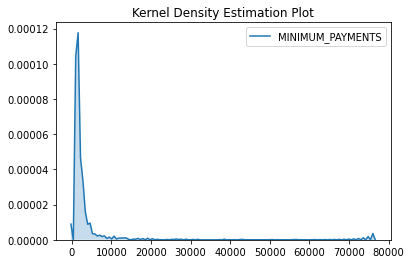

In [5]:
sns.kdeplot(data['MINIMUM_PAYMENTS'], shade=True) 
plt.title('Kernel Density Estimation Plot') 
data['MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].fillna(data['MINIMUM_PAYMENTS'].median())

In [6]:
pd.isnull(data).sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

<a id="Feature-Distribution"></a>

**Feature Distribution**<a></a>

KDE (Kernel Density Estimation) plot for each feature

Text(0.5, 0.98, 'Kernel Density Estimation Plot')

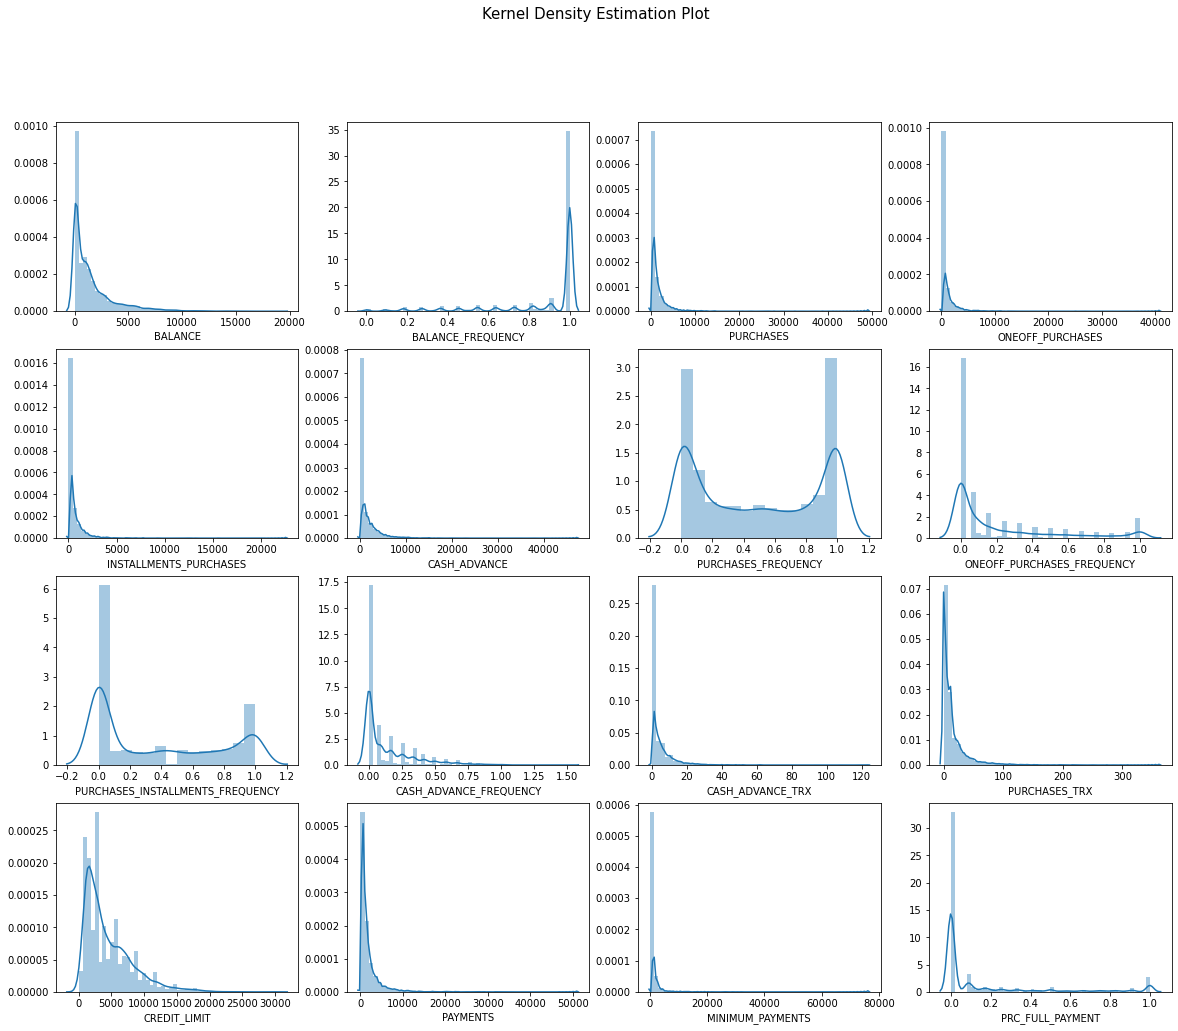

In [7]:
data_dist=data.iloc[:,1:17]
data_columns=data_dist.columns

r,c=0,0
fig, axes=plt.subplots(4,4, figsize=(20,16))
#plt.tight_layout()
for i in data_columns:
    sns.distplot(data[i], ax=axes[r,c])
    c += 1
    if c == 4: 
        r += 1
        c=0
    if r == 4: break
plt.suptitle('Kernel Density Estimation Plot', fontsize=15)

<a id="Outliers-Treatment"></a>

**Outliers Treatment**<a></a>

There are 2 ways:
1. Remove: If the observations are wrongly recorded (e.g., credit limit is not in accordance with bank's regulation), we directly remove the observations. 
2. Keep: Replace that features with their square root value or log value to downsize outliers impact.

What we do:
1. Since there is no evidence shows there are observations wrongly recorded, we do not remove outliers.
2. Z-score is used to identify which features with more than 2% outliers (absolute z-score >3) in themselves, and replace them with thier square root value.

In [8]:
from scipy import stats
data1=data.drop(columns=['CUST_ID', 'TENURE']) # drop string feature and features with meaningful range
z_score=pd.DataFrame(np.abs(stats.zscore(data1)), columns=data1.columns) # calculate z-score

# Find out features with more than 2% outliers (absolute z-score >3)
z_score3=[]
over3_index=[] 
for i in z_score.columns:
    indexs=z_score.index[z_score[i] > 3].tolist()
    ans=i, "{:.3f}".format(len(indexs)/len(z_score)), indexs
    z_score3.append(ans) 
    if len(indexs)/len(z_score) > 0.02:
        over3_index.append(i)  

# remove 'BALANCE' and 'CASH_ADVANCE' since thay are regarded as high discriminative features
del over3_index[0]
del over3_index[1]

# replace 'BALANCE_FREQUENCY','CASH_ADVANCE_FREQUENCY', and 'PURCHASES_TRX' with their square root value
for i in over3_index:
    data1['sqrt_%s' % i]=data1[i].apply(np.sqrt)

In [9]:
print('feature: ', list(data1.columns))
print('data shape: ', data1.shape)

feature:  ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'sqrt_BALANCE_FREQUENCY', 'sqrt_CASH_ADVANCE_FREQUENCY', 'sqrt_PURCHASES_TRX']
data shape:  (8949, 19)


<a id="Correlation-Matrix"></a>

**Correlation Matrix**<a></a>

Note:
To avoid the top and bottom boxes are cut off, we need to downgrade matplotlib (conda install -c conda-forge matplotlib=3.1.2)

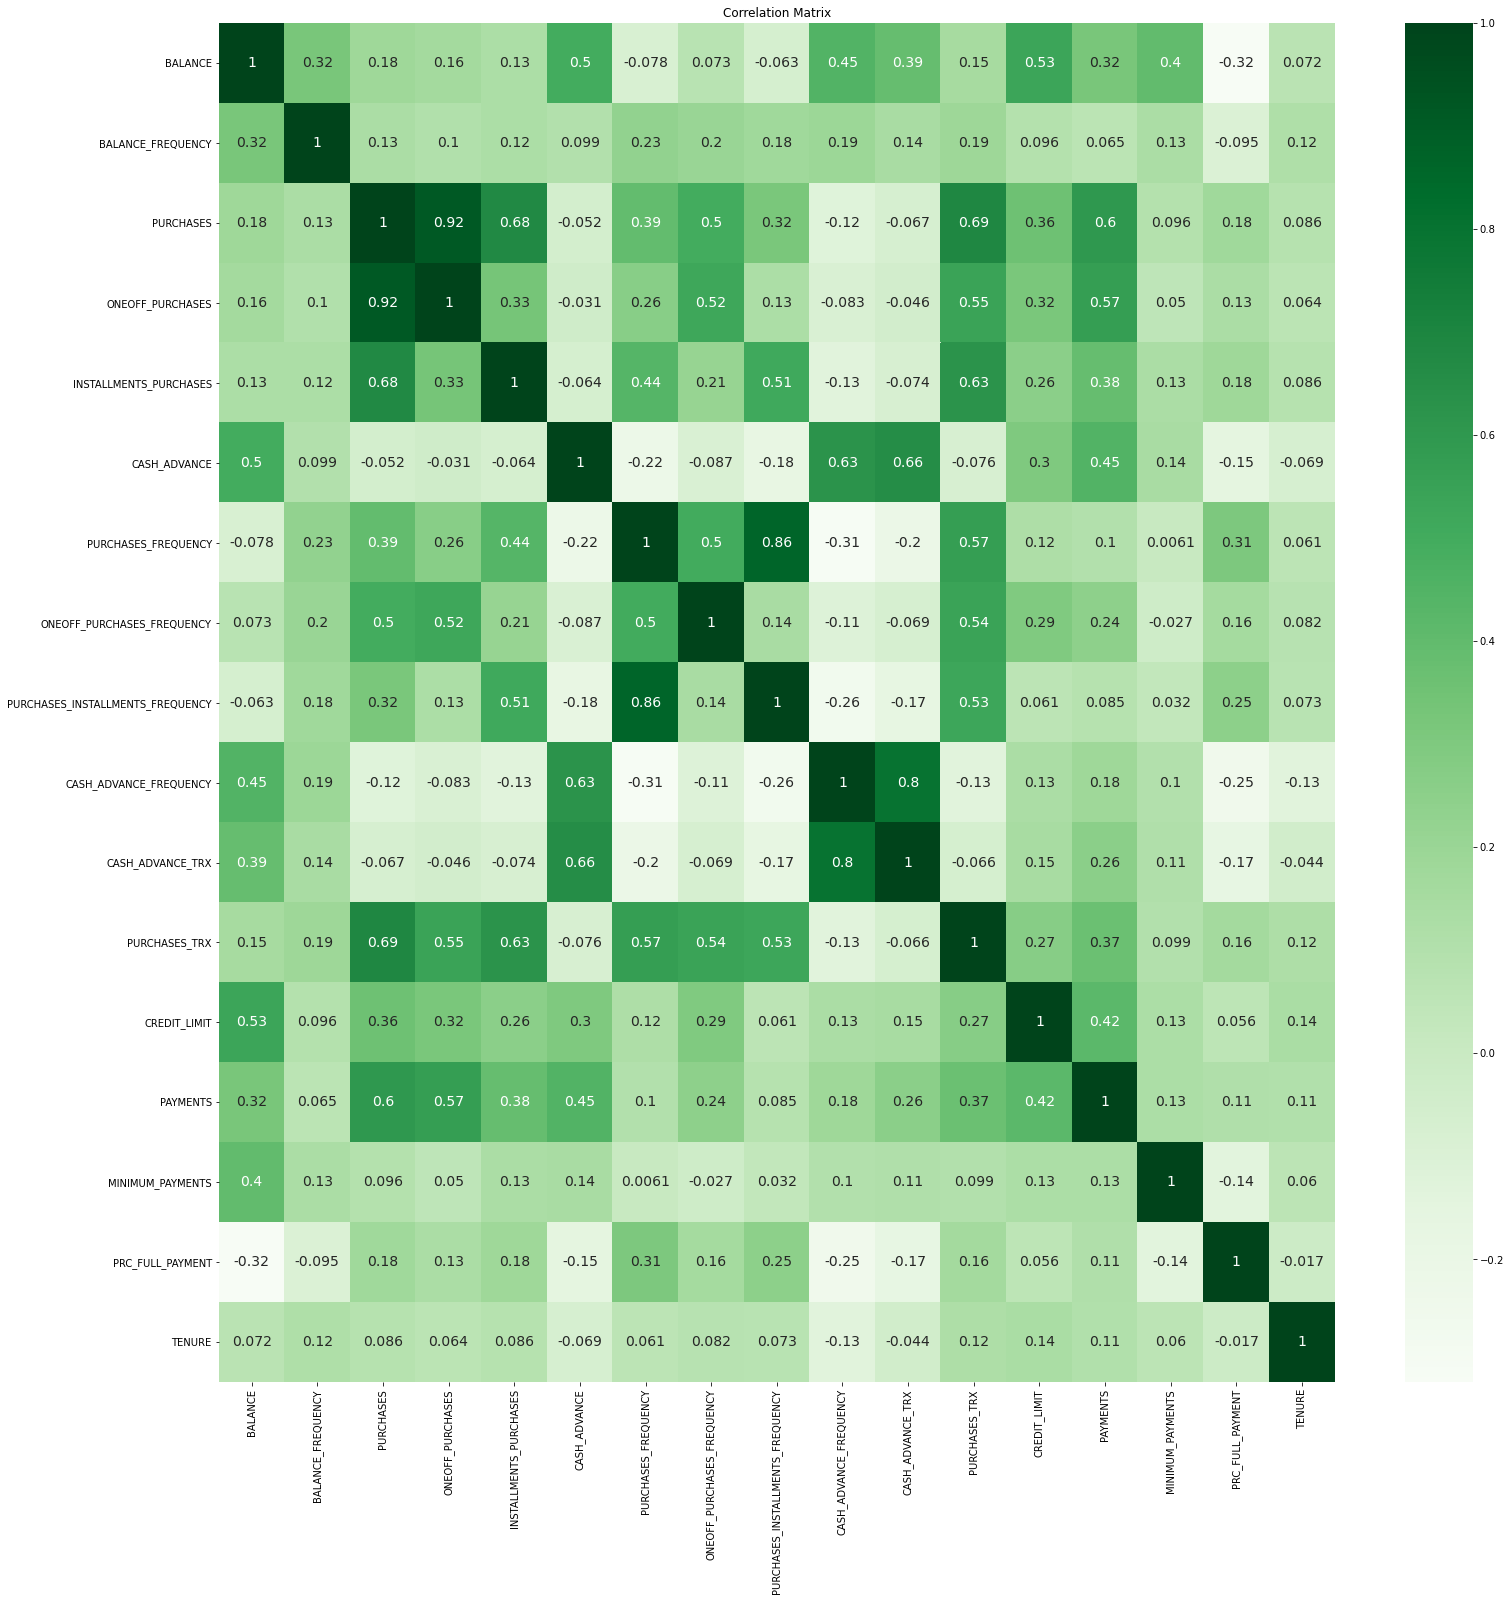

In [10]:
corr_coef=data[1:].corr()

# Heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_coef, cmap='Greens', annot=True, annot_kws={'size':14},
            xticklabels=corr_coef.columns,
            yticklabels=corr_coef.columns)
plt.title('Correlation Matrix')

# Find out feature pairs whose coefficient >= 0.7
corr_cols=corr_coef.columns.to_list() 
signif_corr=[]
for i in range(len(corr_cols)):
    col=corr_cols[i]
    signif_corr.append(abs(corr_coef[col])[abs(corr_coef[col]) >= 0.7])
signif_corr_df=pd.DataFrame(signif_corr)
#signif_corr_df['PURCHASES']['ONEOFF_PURCHASES'] 

High Correlation Coefficient Pairs Analysis:

* PURCHASES & ONEOFFPURCHASES: 0.92

When people use one-off purchases, purchase amount is higher than using installment purchases.

* PURCHASESFREQUENCY & PURCHASESINSTALLMENTSFREQUENCY: 0.86

More people use installment purchases.

* CASHADVANCEFREQUENCY & CASHADVANCETRX: 0.80


Text(0.5, 1.0, 'Kernel Density Estimation Plot')

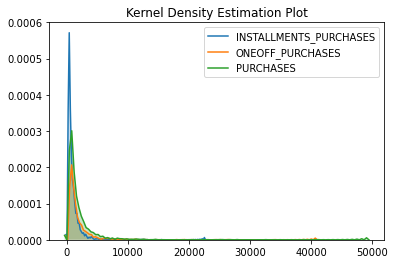

In [11]:
sns.kdeplot(data1['INSTALLMENTS_PURCHASES'], shade=True)
sns.kdeplot(data1['ONEOFF_PURCHASES'], shade=True)
sns.kdeplot(data1['PURCHASES'], shade=True)
plt.title('Kernel Density Estimation Plot')

Text(0.5, 1.0, 'Kernel Density Estimation Plot')

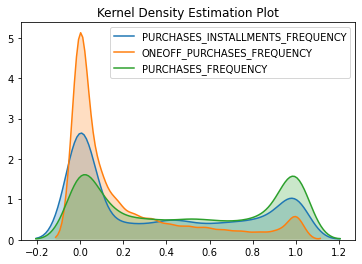

In [12]:
sns.kdeplot(data1['PURCHASES_INSTALLMENTS_FREQUENCY'], shade=True)
sns.kdeplot(data1['ONEOFF_PURCHASES_FREQUENCY'], shade=True)
sns.kdeplot(data1['PURCHASES_FREQUENCY'], shade=True)
plt.title('Kernel Density Estimation Plot')

<a id="Create-Interaction-Features"></a>

**Create Interaction Features**<a></a>

We can understand clients' purchase level or preference by knowing their average purchase amount, however we only got frequency for one-off and installment purchase or cash advance form this dataset.

Frequency data is reagarded as metric of number of transaction since number of transaction divided by some value will be frequency. (The higher frequency is, the less average purchase amount is)

Below are the formulas:
1. Average one-off purchase amount = 'ONEOFF_PURCHASES'/'ONEOFF_PURCHASES_FREQUENCY'
2. Average installment purchase amount = 'INSTALLMENTS_PURCHASES'/'PURCHASES_INSTALLMENTS_FREQUENCY'
3. Average can advance amount = 'CASH_ADVANCE'/'CASH_ADVANCE_TRX'

In [13]:
data1['avg_oneoff_purchases']=data1['ONEOFF_PURCHASES']/data1['ONEOFF_PURCHASES_FREQUENCY']
data1['avg_oneoff_purchases']=data1['avg_oneoff_purchases'].fillna(0)

data1['avg_installment_purchases']=data1['INSTALLMENTS_PURCHASES']/data1['PURCHASES_INSTALLMENTS_FREQUENCY']
data1['avg_installment_purchases']=data1['avg_installment_purchases'].fillna(0)

data1['avg_cash_advance']=data1['CASH_ADVANCE']/data1['CASH_ADVANCE_TRX']
data1['avg_cash_advance']=data1['avg_cash_advance'].fillna(0)

<a id="Feature-Digitization"></a>

**Feature Digitization**<a></a>

Digitize features into 8 ranges except 'TENURE' (due to its meaningful own range)

In [14]:
import math
digit_index=list(data1.columns)

for i in digit_index:
    max_v=math.ceil(data1[i].describe()['max'])
    min_v=math.floor(data1[i].describe()['min'])
    bins_range=np.arange(min_v, max_v, (max_v-min_v)/8)    
    data1['digit_%s' % i]=np.digitize(data1[i], bins=bins_range)
    #print(np.unique(data1['digit_%s' % i], return_counts=True))

data1['CUST_ID']=data['CUST_ID']
data1['TENURE']=data['TENURE']

In [15]:
print('data shape: ', data1.shape)

data shape:  (8949, 46)


# **Modeling**<a></a>

In [16]:
from sklearn.preprocessing import Normalizer, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV

Design pipelines to select numerical and categorical features

Note: Since sklearn cannot directly handle DataFrames, we need to define a function to transform it into numpy


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names] 

In [18]:
categ=list(data1.columns)[22:44]
categ1=np.delete(categ,[1, 9, 11]).tolist()
numer=['TENURE']

print('Categorical Features: ', categ1)
print('Numerical Feature: ', numer)

Categorical Features:  ['digit_BALANCE', 'digit_PURCHASES', 'digit_ONEOFF_PURCHASES', 'digit_INSTALLMENTS_PURCHASES', 'digit_CASH_ADVANCE', 'digit_PURCHASES_FREQUENCY', 'digit_ONEOFF_PURCHASES_FREQUENCY', 'digit_PURCHASES_INSTALLMENTS_FREQUENCY', 'digit_CASH_ADVANCE_TRX', 'digit_CREDIT_LIMIT', 'digit_PAYMENTS', 'digit_MINIMUM_PAYMENTS', 'digit_PRC_FULL_PAYMENT', 'digit_sqrt_BALANCE_FREQUENCY', 'digit_sqrt_CASH_ADVANCE_FREQUENCY', 'digit_sqrt_PURCHASES_TRX', 'digit_avg_oneoff_purchases', 'digit_avg_installment_purchases', 'digit_avg_cash_advance']
Numerical Feature:  ['TENURE']


In [19]:
numerical_pipeline=Pipeline([('selector', DataFrameSelector(numer)),
                             ('RobustScaler', RobustScaler())])

categorical_pipeline=Pipeline([('selector', DataFrameSelector(categ1)),
                             ('OneHotEncoder', OneHotEncoder())])

selector_pipeline=FeatureUnion([('numerical_pipeline', numerical_pipeline),
                                ('categorical_pipeline', categorical_pipeline)])

<a id="Evaluation-Metric---Silhouette-Score"></a>

**Evaluation Metric - Silhouette Score**<a></a>

In [20]:
def silhouette_score_cal(estimator,data):       
    preprocess=FeatureUnion([('selector_pipeline', selector_pipeline), 
                             ('Normalizer', Normalizer(norm='l2')),
                             ('pca', PCA(n_components=15))])            
    trans_results=preprocess.fit_transform(data)          
    clusters=estimator.fit_predict(data)
    score=silhouette_score(trans_results, clusters)
    return score

<a id="Model---KMeans"></a>

**Model - KMeans**<a></a>

In [21]:
categ_copy=categ1.copy()
categ_copy.append('TENURE')
data_model=data1[categ_copy]

preprocess=FeatureUnion([('selector_pipeline', selector_pipeline), 
                             ('Normalizer', Normalizer(norm='l2')),
                             ('pca', PCA(n_components=15))])

trans_results=preprocess.fit_transform(data_model)  # for visualization    
kmeans=Pipeline([('preprocess', preprocess), ('kmeans', KMeans())])     
search_space=[{'kmeans__n_clusters':np.arange(3,10)}] # test various(3-9) n_clusters
cv = [(slice(None), slice(None))]

gs=GridSearchCV(estimator=kmeans,param_grid=search_space, 
                scoring=silhouette_score_cal,cv=cv, n_jobs=-1)

best_model=gs.fit(data_model)

**Best Model Results**


In [22]:
print('best model - number of cluster: ', best_model.best_params_)
print('best model - Silhouette Score: ', best_model.best_score_)
grid_predict=best_model.predict(data_model)
data1['cluster']=grid_predict
grid_results=best_model.cv_results_
print('number of observations in each cluster: ', list(np.unique(grid_predict, return_counts=True)[1])) 

best model - number of cluster:  {'kmeans__n_clusters': 3}
best model - Silhouette Score:  0.3433068237443467
number of observations in each cluster:  [4518, 1604, 2827]


# **Visualization**<a></a>

<a id="Line-Plot---Silhouette-Score-under-Various-Number-of-Cluster"></a>

Line Plot - Silhouette Score under Various Number of Cluster<a></a>

Text(0.5, 1.0, 'Silhouette Score under Various Number of Cluster')

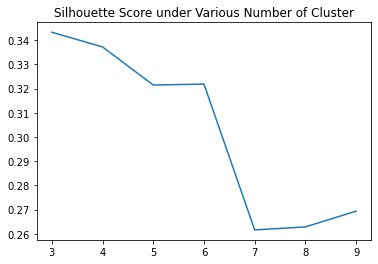

In [23]:
grid_scores=grid_results['mean_test_score']
plt.plot(range(3,10), grid_results['mean_test_score'])
plt.title('Silhouette Score under Various Number of Cluster')

<a id="Scatter-Plot---Cluster-Results"></a>

Scatter Plot - Cluster Results <a></a>

Text(0.5, 1.0, 'Clustering Results Visualization')

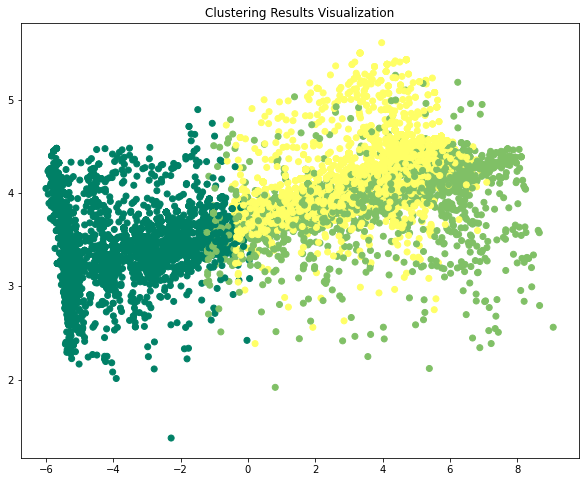

In [24]:
df_visual=pd.DataFrame(TruncatedSVD(n_components=2).fit_transform(trans_results), columns=['p1','p2'])

plt.figure(figsize=(10,8))
plt.scatter(df_visual['p1'], df_visual['p2'], c=grid_predict, cmap=plt.cm.summer)
plt.title('Clustering Results Visualization')

<a id="Histogram---Features-Value-of-Each-Cluster"></a>

Histogram - Features Value of Each Cluster<a></a>

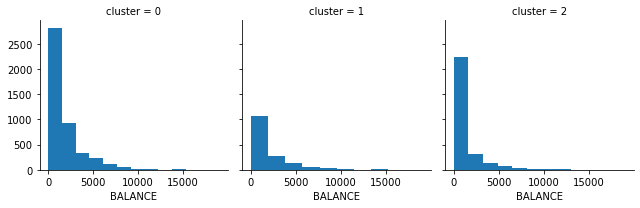

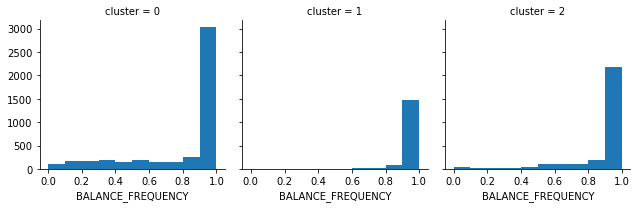

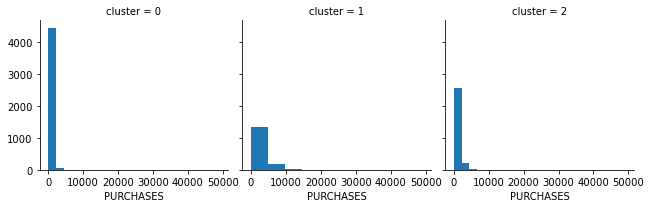

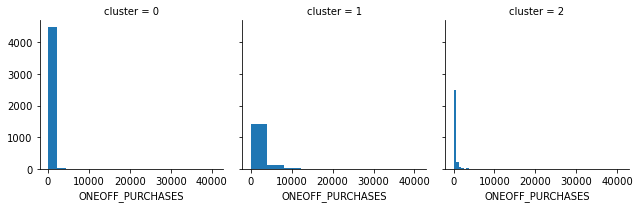

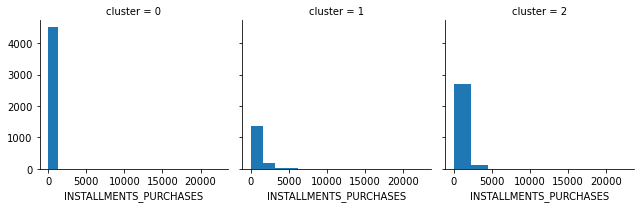

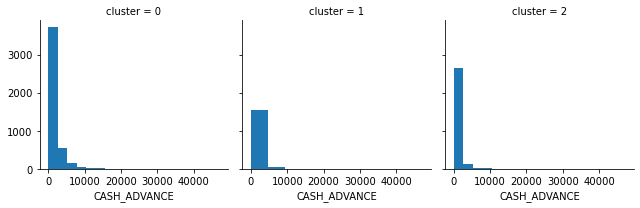

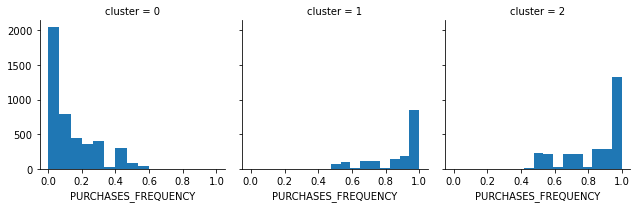

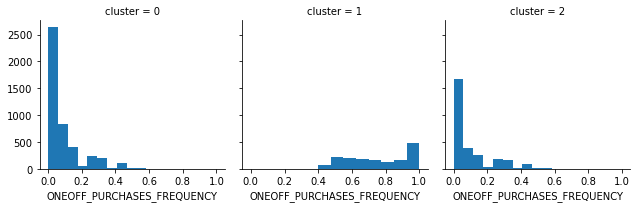

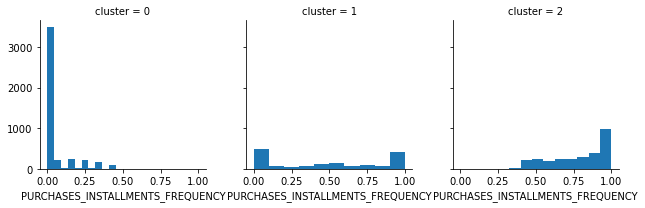

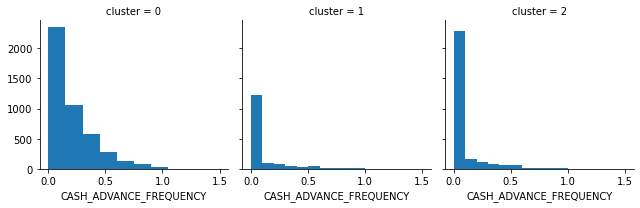

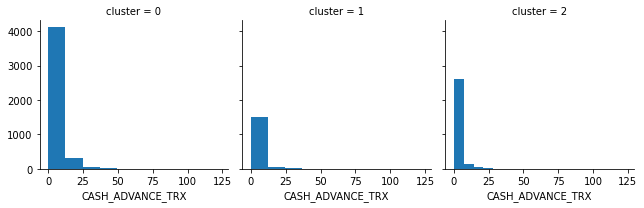

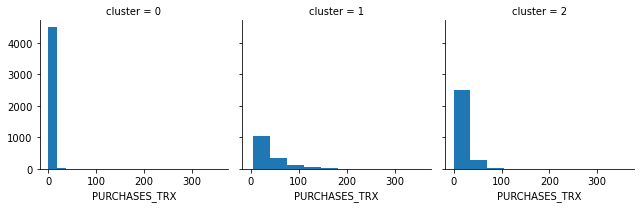

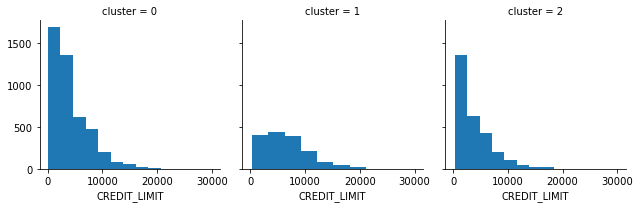

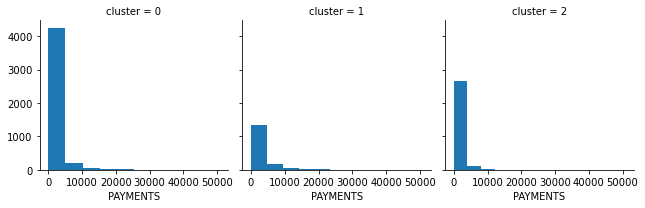

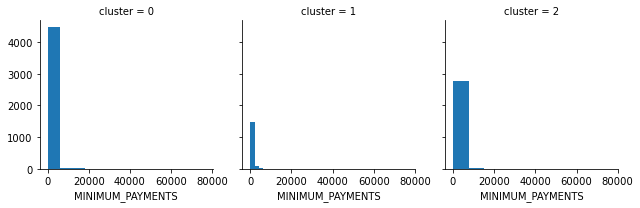

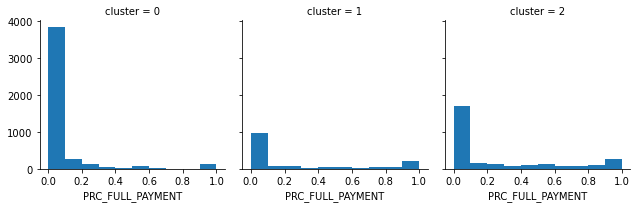

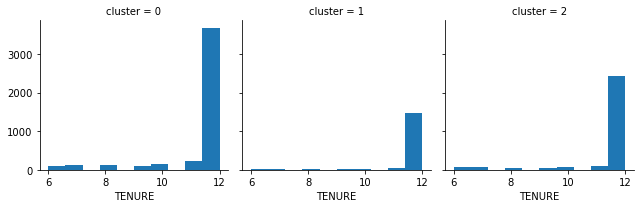

In [25]:
for feature in list(data.columns[1:]):
    g=sns.FacetGrid(data1, col='cluster')
    g=g.map(plt.hist, feature)

Feature Value (Mean Value) of Each Cluster

In [26]:
data1.insert(0, 'TENURE', data1['TENURE'], allow_duplicates=True) # just for convience
each_cluster=data1.groupby('cluster').mean().iloc[:, :23]
each_cluster

,TENURE,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,...,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,sqrt_BALANCE_FREQUENCY,sqrt_CASH_ADVANCE_FREQUENCY,sqrt_PURCHASES_TRX,avg_oneoff_purchases,avg_installment_purchases,avg_cash_advance
cluster,,,,,,,,,,,,,,,,,,,,,
0,11.434263,1701.059772,0.825550,267.093417,218.980228,48.260611,1369.500356,0.127074,0.075328,0.050415,...,4110.138973,1477.572112,822.992455,0.066245,0.886964,0.335882,1.031779,1281.377703,242.542125,307.260183
1,11.749377,1942.748340,0.971522,3095.099632,2280.720599,814.379034,688.020380,0.880090,0.769058,0.487313,...,6658.757651,3154.249599,780.092640,0.255171,0.984154,0.162671,5.950500,2974.033121,1128.071425,116.614037
2,11.520340,1132.109982,0.906703,993.072299,231.583290,762.203753,519.887621,0.849966,0.084222,0.796706,...,3880.641309,1335.883012,917.009745,0.235995,0.939915,0.130322,4.091096,1181.703729,965.438494,104.090385


<a id="Render-Plot---Features-Value-of-Each-Cluster"></a>

Render Plot - Features Value of Each Cluster<a></a>

Split features into 3 parts based on value reange (low, high, top)

In [27]:
high=['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
      'MINIMUM_PAYMENTS']
low=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 
     'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 
     'PURCHASES_TRX','PRC_FULL_PAYMENT', 'TENURE']
top=['CREDIT_LIMIT', 'PURCHASES', 'PAYMENTS']

each_cluster_high=each_cluster[high].T
each_cluster_low=each_cluster[low].T
each_cluster_top=each_cluster[top].T

In [28]:
def render_plot(data, dataLenth, labels, color, facecolor):    
    angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
    data, angles = np.concatenate((data, [data[0]])), np.concatenate((angles, [angles[0]])) # for visualize circle
        
    ax = fig.add_subplot(121, polar=True)# polar: drawing circle
    ax.plot(angles, data, color, linewidth=1)
    ax.fill(angles, data, facecolor=facecolor, alpha=0.1)# fill color
    ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
    ax.set_title("Feature Value of Each Cluster", va='baseline', fontproperties="SimHei")
    ax.grid(True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


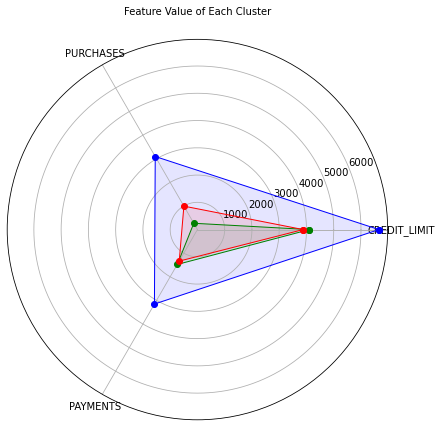

In [29]:
fig = plt.figure(figsize=(15,15))
labels = np.array(list(each_cluster_top.index))
render_plot(each_cluster_top.iloc[:,0], len(each_cluster_top.iloc[:,0]), labels,'go-', 'g')
render_plot(each_cluster_top.iloc[:,1], len(each_cluster_top.iloc[:,0]), labels,'bo-', 'b')
render_plot(each_cluster_top.iloc[:,2], len(each_cluster_top.iloc[:,0]), labels,'ro-', 'r')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<Figure size 432x288 with 0 Axes>

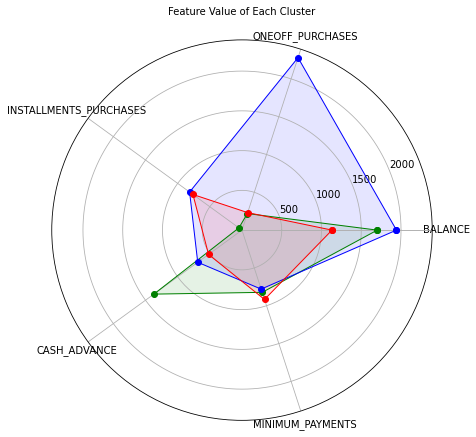

In [30]:
fig=plt.figure()
fig = plt.figure(figsize=(15,15))
labels = np.array(list(each_cluster_high.index))
render_plot(each_cluster_high.iloc[:,0], len(each_cluster_high.iloc[:,0]), labels,'go-', 'g')
render_plot(each_cluster_high.iloc[:,1], len(each_cluster_high.iloc[:,0]), labels,'bo-', 'b')
render_plot(each_cluster_high.iloc[:,2], len(each_cluster_high.iloc[:,0]), labels,'ro-', 'r')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


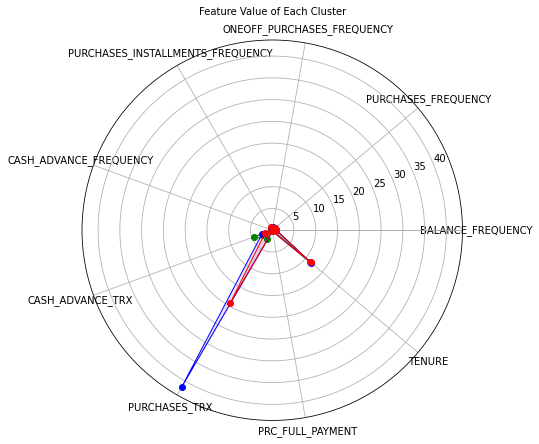

In [31]:
fig = plt.figure(figsize=(15,15))
labels = np.array(list(each_cluster_low.index))
render_plot(each_cluster_low.iloc[:,0], len(each_cluster_low.iloc[:,0]), labels,'go-', 'g')
render_plot(each_cluster_low.iloc[:,1], len(each_cluster_low.iloc[:,0]), labels,'bo-', 'b')
render_plot(each_cluster_low.iloc[:,2], len(each_cluster_low.iloc[:,0]), labels,'ro-', 'r')

# **Features of customers in each group**<a></a>

**Group Red**: Big spender with high balance, credit limit, and payments who mostly take one-off purchases.

**Group Green**: Medium spender with low balance who take less cash advance and purchase mostly in installments.

**Group Blue**: Small spender with medium balance who take more cash advance and seldom purchase in installments.